In [1]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
data_train_neg = np.fromfile("/content/drive/MyDrive/exp1-train-2000neg.bin", dtype=np.float32).reshape([2000,5,768])
#data_train_neg2 = np.fromfile("/content/drive/MyDrive/exp2-train-2000neg.bin", dtype=np.float32).reshape([2000,5,768])
#data_train_neg = np.concatenate((data_train_neg1,data_train_neg2),axis = 0)

data_train_pos = np.fromfile("/content/drive/MyDrive/exp1-train-400pos.bin", dtype=np.float32).reshape([400,5,768])
#data_train_pos2 = np.fromfile("/content/drive/MyDrive/exp2-train-400pos.bin", dtype=np.float32).reshape([400,5,768])
#data_train_pos= np.concatenate((data_train_pos1,data_train_pos2),axis=0) 


data_test= np.fromfile("/content/drive/MyDrive/exp22-test-1200.bin", dtype=np.float32).reshape([1200,5,768])


In [49]:
Y = np.concatenate((np.zeros(data_train_neg.shape[0]),np.ones(data_train_pos.shape[0])), axis = 0)
ts_data = np.concatenate((data_train_neg,data_train_pos),axis = 0)


In [50]:
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import tensorflow as tf
from keras.regularizers import l2

In [51]:

clear_session()
model = Sequential()
model.add(Conv1D(filters=5,kernel_size=10,strides=1,input_shape=(768,5)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPool1D(pool_size=4,strides=4))


model.add(Conv1D(filters=5,kernel_size=5,strides=1,))
model.add(LeakyReLU())
model.add(MaxPool1D(pool_size=4,strides=4))#4
model.add(Dropout(0.5))


model.add(Conv1D(filters=5,kernel_size=5,strides=1))#5
model.add(LeakyReLU())
model.add(AveragePooling1D(pool_size=4,strides=2))#6
model.add(Dropout(0.5))

model.add(Conv1D(filters=5,kernel_size=5,strides=1))#7    
model.add(LeakyReLU())
model.add(AveragePooling1D(pool_size=4,strides=2))#8

model.add(Conv1D(filters=5,kernel_size=5,strides=1))#9
model.add(LeakyReLU())
model.add(GlobalAveragePooling1D())#10
model.add(Dense(200,activation="relu"))

model.add(Dense(1,activation='sigmoid'))

model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])




              

    


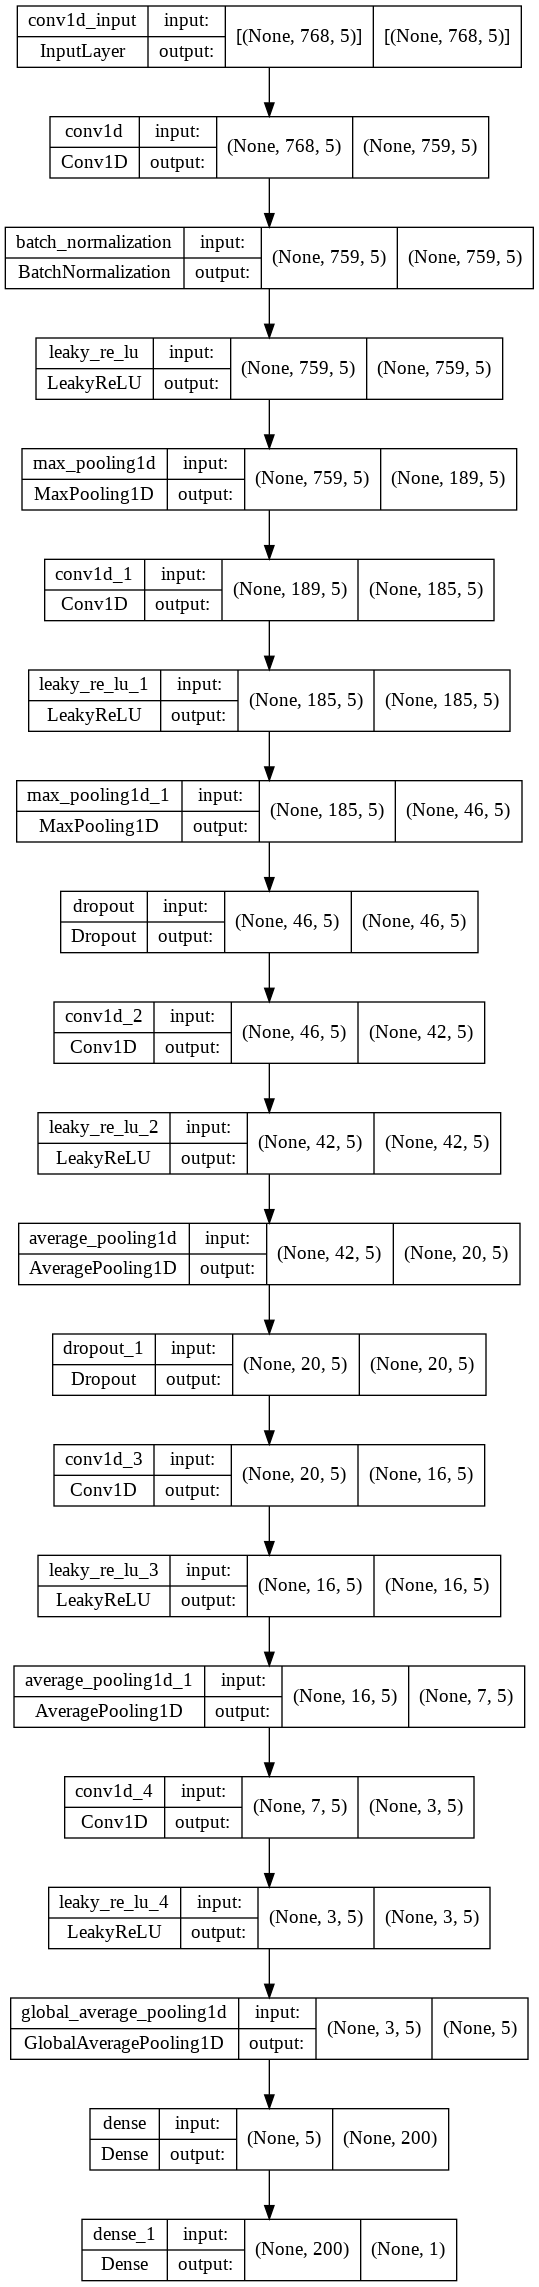

In [52]:
# visiualisation of the strcuture

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [53]:
from sklearn.model_selection import train_test_split,KFold
from tensorflow.keras.optimizers.schedules import PolynomialDecay  
from tensorflow.keras.optimizers import Adam
ts_data =  np.moveaxis(ts_data,1,2)
kf = KFold(n_splits=5,shuffle=True)


In [54]:
import time

In [56]:
acc_per_fold = []
loss_per_fold = []
epchs= 50
batch_sz= 20

start = time.time()
fold_no = 1
for train, test in kf.split(ts_data,Y):


  num_train_steps = (len(ts_data[train]))*epchs
  print(num_train_steps)
  lr_shdler = PolynomialDecay(initial_learning_rate= 0.01,end_learning_rate= 0.0001 ,decay_steps = 10000)
  opt = Adam( learning_rate=  lr_shdler)
  model.compile(optimizer = opt,loss='binary_crossentropy',metrics=['accuracy'])
  

  R = model.fit(ts_data[train], Y[train], epochs= epchs,batch_size=batch_sz)
  scores = model.evaluate(ts_data[test], Y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1
end = time.time()



96000
Epoch 1/50
96/96 [==============================] - 3s 18ms/step - loss: 0.1428 - accuracy: 0.9563
Epoch 2/50
96/96 [==============================] - 2s 16ms/step - loss: 0.1279 - accuracy: 0.9578
Epoch 3/50
96/96 [==============================] - 2s 16ms/step - loss: 0.1138 - accuracy: 0.9625
Epoch 4/50
96/96 [==============================] - 2s 16ms/step - loss: 0.1246 - accuracy: 0.9646
Epoch 5/50
96/96 [==============================] - 2s 18ms/step - loss: 0.1050 - accuracy: 0.9714
Epoch 6/50
96/96 [==============================] - 2s 18ms/step - loss: 0.1083 - accuracy: 0.9677
Epoch 7/50
96/96 [==============================] - 2s 17ms/step - loss: 0.1029 - accuracy: 0.9682
Epoch 8/50
96/96 [==============================] - 2s 17ms/step - loss: 0.0991 - accuracy: 0.9651
Epoch 9/50
96/96 [==============================] - 1s 16ms/step - loss: 0.1114 - accuracy: 0.9656
Epoch 10/50
96/96 [==============================] - 2s 16ms/step - loss: 0.1073 - accuracy: 0.9641
Epo

In [60]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


print(f"The time cost is :{end-start}s")

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.10211028903722763 - Accuracy: 97.70833253860474%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.046576619148254395 - Accuracy: 98.7500011920929%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.055420972406864166 - Accuracy: 97.50000238418579%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.05503161624073982 - Accuracy: 98.54166507720947%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.04245623201131821 - Accuracy: 98.33333492279053%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 98.16666722297668 (+- 0.48232618061716837)
> Loss: 0.060319145768880846
-------------------

In [46]:
ts_test_ = np.moveaxis(data_test,1,2)
Y_test_ = model.predict(ts_test_)
Y_test_[Y_test_>0.5] = 1
Y_test_

array([[1.0000000e+00],
       [5.1966310e-04],
       [5.5134278e-06],
       ...,
       [3.8730004e-06],
       [1.8171221e-02],
       [7.9247320e-07]], dtype=float32)

In [47]:
import csv 
with open('./result-CONV1D2.csv','w',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['Outcome','Id'])
  for i in range(ts_test_.shape[0]):
      writer.writerow([int(Y_test_[i]),i])